#HW 10 CLUSTERING BUSINESS

In [150]:
import pandas as pd
import geopandas as gp
from zipfile import ZipFile
import numpy as np
import pylab as pl
import urllib2
import os
import json
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
%pylab inline

from __future__ import print_function
__author__='djc'

s = json.load(open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json'))
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


##Task 1: Get and Clean Data
###Census Business data by ZIP code:
http://www.census.gov/econ/cbp/download/

###NYC zipcode shapefiles here:
http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


DJC note: Seems to be an error with the URL for 2000, and 2001, but I didnt have time to investigate more thoroughly, so those need to be downloaded manually.

In [2]:
#! for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#! for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#! for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

In [3]:
# read in NYC zipcode shapefiles
df_shape = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
df_shape['zip_code'] = df_shape.postalCode.astype(int)

In [5]:
# unzip and read in county bizdata by year, 
# filter by NYC zip codes, aggregate into 1 timeseries dataframe
years = ['94','95','96','97','98',
         '99','00','01','02','03',
         '04','05','06','07','08','09',
         '10','11','12','13']

df_rawdata = pd.DataFrame(df_shape.zip_code)
for i in years:
    fname = 'zbp{}totals.zip'.format(i)
    zf = ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df = df.rename(columns = {'ZIP':'zip','EST':'est'})    
    df['zip_code'] = df['zip'].astype(int)
    df = df[df['zip_code'].isin(df_shape['zip_code'])]
    df = df[['zip_code', 'est']].reset_index(drop = True)
    df_rawdata['est_{}'.format(i)] = df.est
df_rawdata = df_rawdata.set_index('zip_code')
print (df_rawdata.shape)
df_rawdata.head()

(262, 20)


,est_94,est_95,est_96,est_97,est_98,est_99,est_00,est_01,est_02,est_03,est_04,est_05,est_06,est_07,est_08,est_09,est_10,est_11,est_12,est_13
zip_code,,,,,,,,,,,,,,,,,,,,
11372,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
11004,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
11040,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
11426,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
11365,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296


In [92]:
# clean out NaNs
df_bizdata = df_rawdata.dropna()
df_bizdata.shape

(236, 20)

###Normalize and Plot timeseries

In [93]:
# normalize timeseries
df_norm = np.asarray(df_bizdata)

for i in range(df_norm.shape[0]):
    mymean = df_norm[i].mean()
    mystd = df_norm[i].std()
    df_norm[i] = (df_norm[i]-mymean)/mystd
print (df_norm.shape)

(236, 20)


In [94]:
# sanity check - means near zero?
#for i in range(df_norm.shape[0]):
#    print ('{}'.format(df_norm[i].mean()))

In [95]:
# sanity check - std 1.0?
#for i in range(df_norm.shape[0]):
#    print ('{}'.format(df_norm[i].std()))

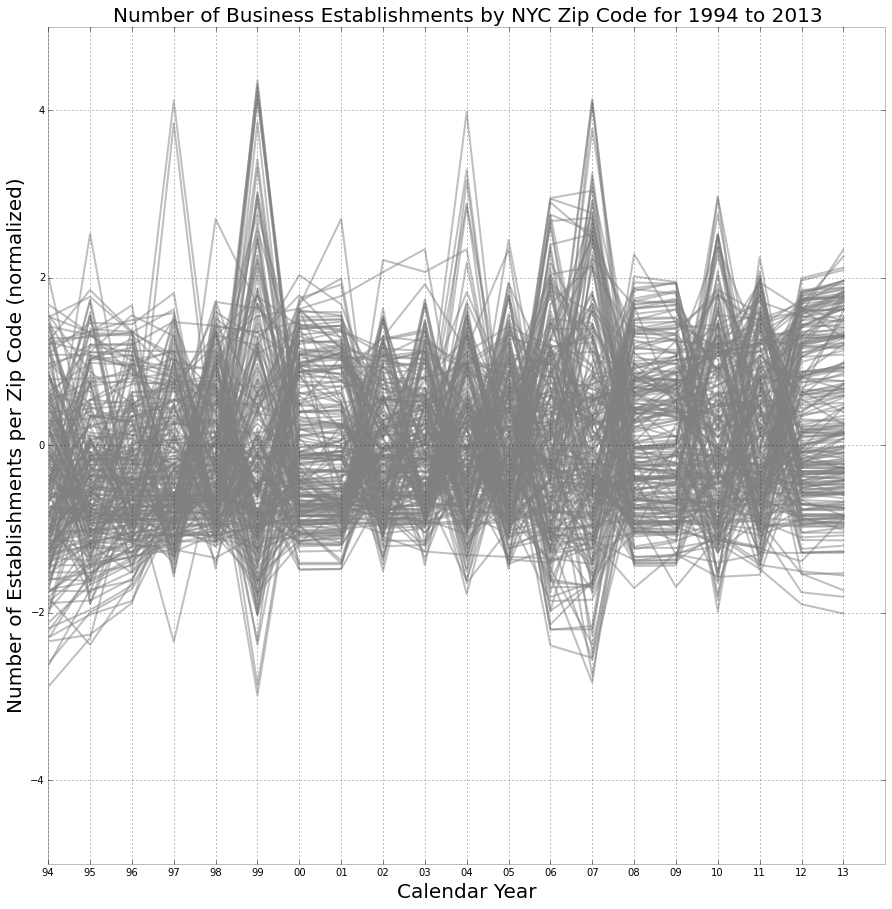

In [109]:
# plot all timeseries
fig = pl.figure(figsize=(15,15))
for i in range(df_norm.shape[0]):
    pl.plot(df_norm[i], '-', color = 'gray', alpha = 0.5)
pl.ylim(-5,5)
pl.title('Number of Business Establishments by NYC Zip Code for 1994 to 2013', fontsize = 20)
pl.ylabel('Number of Establishments per Zip Code (normalized)', fontsize = 20)
pl.xlabel('Calendar Year', fontsize = 20)
pl.xticks(range(len(years)), years);

## Task 2: K-means clustering

In [151]:
# K-means clustering for 3 clusters
kmeans3 = KMeans(n_clusters = 3).fit(df_norm)
centers_km3 = kmeans3.cluster_centers_
labels_km3 = kmeans3.labels_

# K-means clustering for 5 clusters
kmeans5 = KMeans(n_clusters = 5).fit(df_norm)
centers_km5 = kmeans5.cluster_centers_
labels_km5 = kmeans5.labels_

## Task 3: Plotting clusters

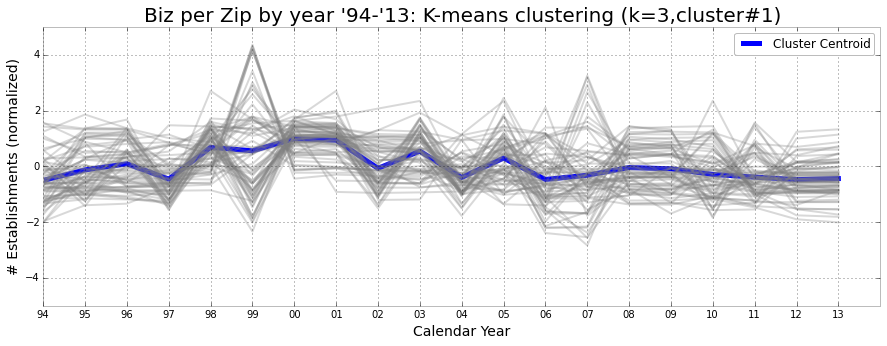

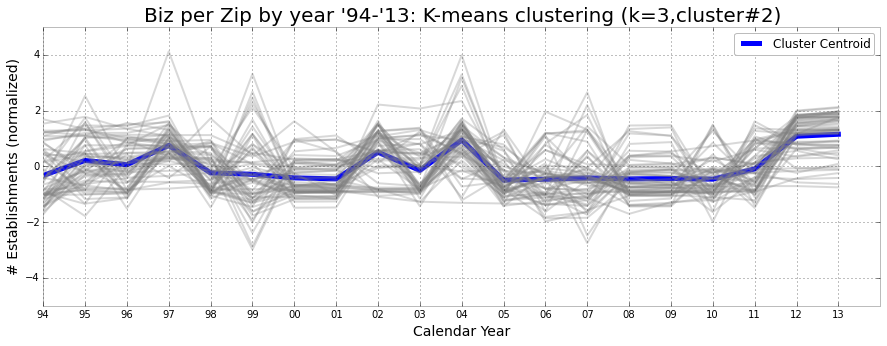

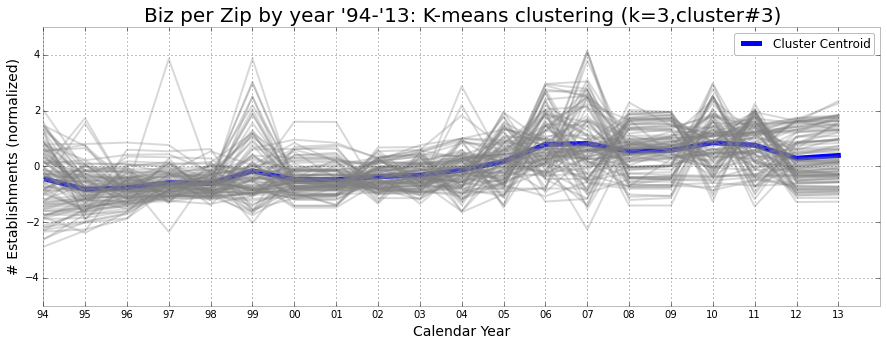

In [178]:
# plot function

def clusterplot(data, k, centers, labels):

    for i in range(k):
        fig = pl.figure(figsize=(15,5))
        pl.plot(centers[i], label = "Cluster Centroid", color = 'b', linewidth = 5)
        for j in range(data.shape[0]):
            if labels[j] == i:
                pl.plot(data[j], color = 'gray', alpha = 0.3)
        
        pl.ylim(-5,5)
        pl.title('Biz per Zip by year \'94-\'13: K-means clustering (k={},' 
                 "cluster#{})".format(k,i+1), fontsize = 20)
        pl.ylabel('# Establishments (normalized)', fontsize = 14)
        pl.xlabel('Calendar Year', fontsize = 14)
        pl.legend()
        pl.xticks(range(len(years)), years);

# plot K-means 3 cluster
clusterplot(df_norm, 3, centers_km3, labels_km3)

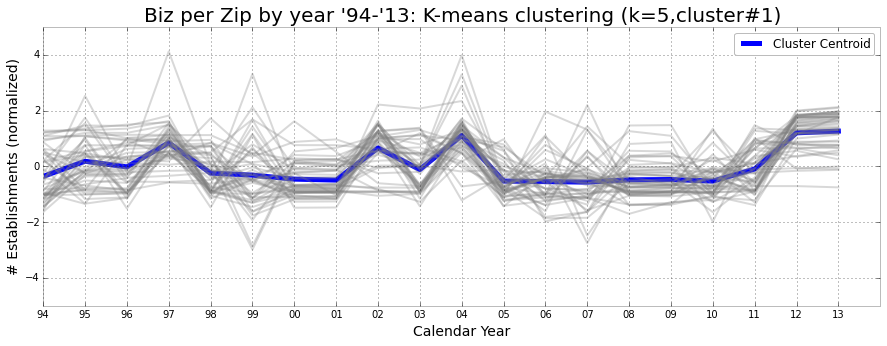

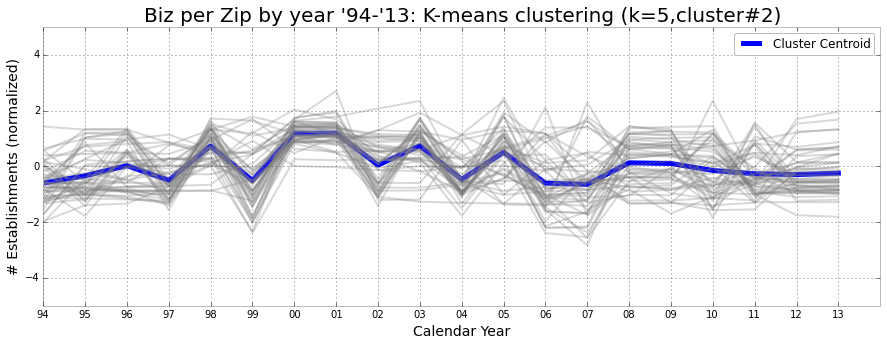

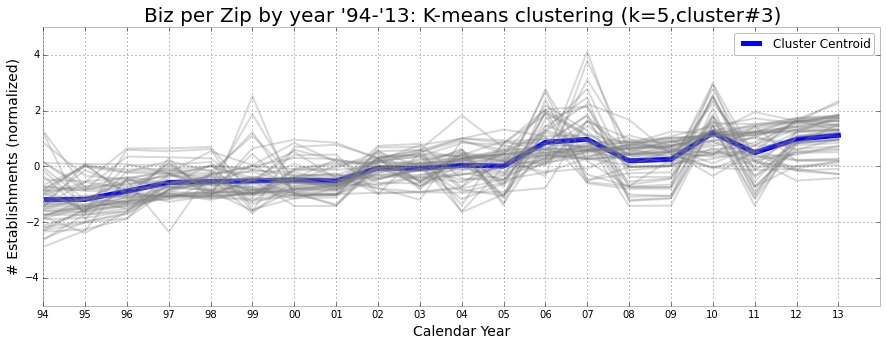

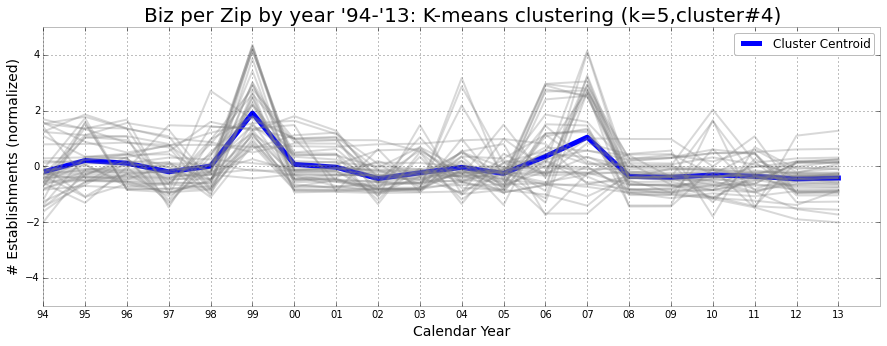

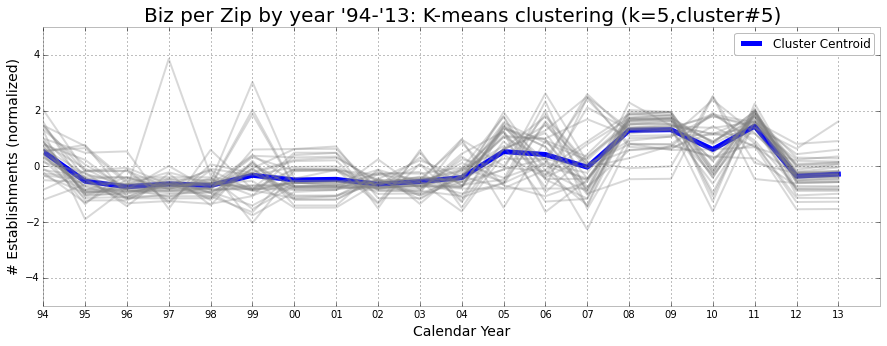

In [168]:
# plot K-means 5 cluster
clusterplot(df_norm, 5, centers_km5, labels_km5)

##Task 4: Agglomerative Clustering

In [191]:
# 3 clusters
agg3 = AgglomerativeClustering(n_clusters = 3).fit(df_norm)
cluster_agg3 = agg3.labels_

# 5 clusters
agg5 = AgglomerativeClustering(n_clusters = 5).fit(df_norm)
cluster_agg5 = agg5.labels_


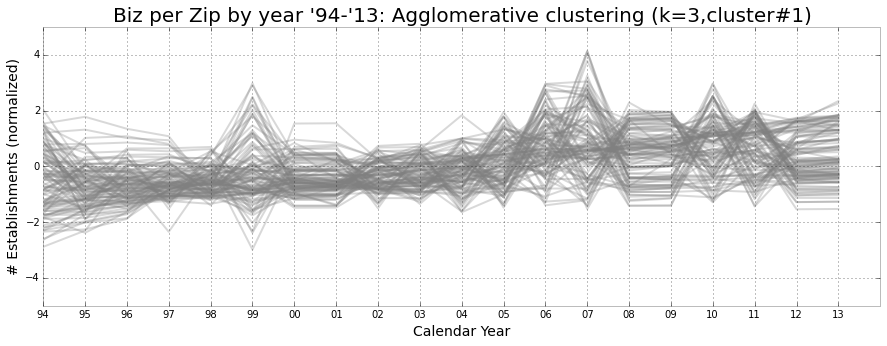

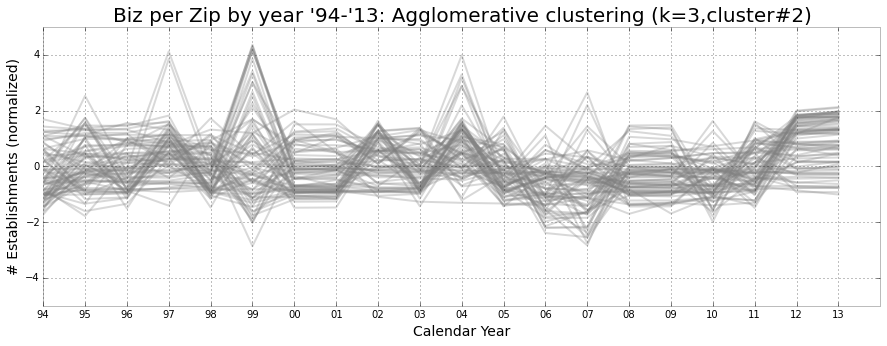

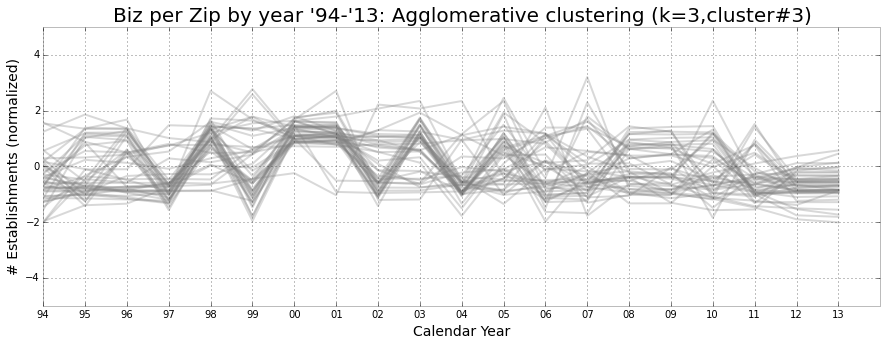

In [192]:
# agg function
def aggplot(data, k, labels):

    for i in range(k):
        fig = pl.figure(figsize=(15,5))
        for j in range(data.shape[0]):
            if labels[j] == i:
                pl.plot(data[j], color = 'gray', alpha = 0.3)
        
        pl.ylim(-5,5)
        pl.title('Biz per Zip by year \'94-\'13: Agglomerative clustering (k={},' 
                 "cluster#{})".format(k,i+1), fontsize = 20)
        pl.ylabel('# Establishments (normalized)', fontsize = 14)
        pl.xlabel('Calendar Year', fontsize = 14)
        pl.xticks(range(len(years)), years);

# agg cluster
aggplot(df_norm, 3, cluster_agg3)

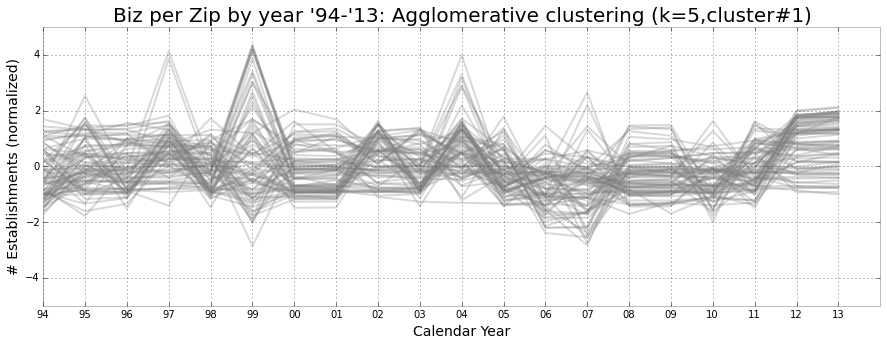

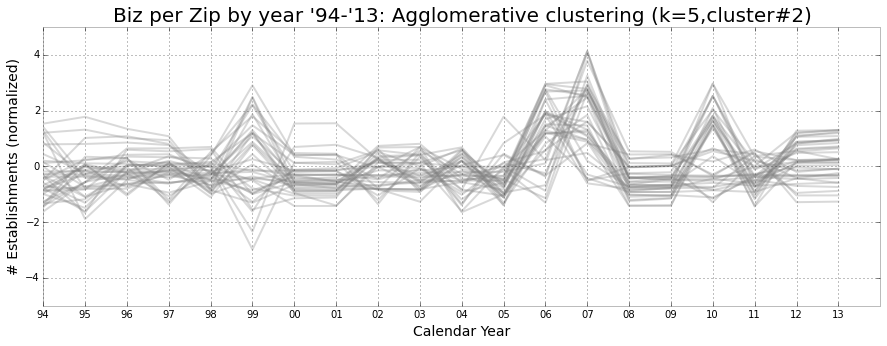

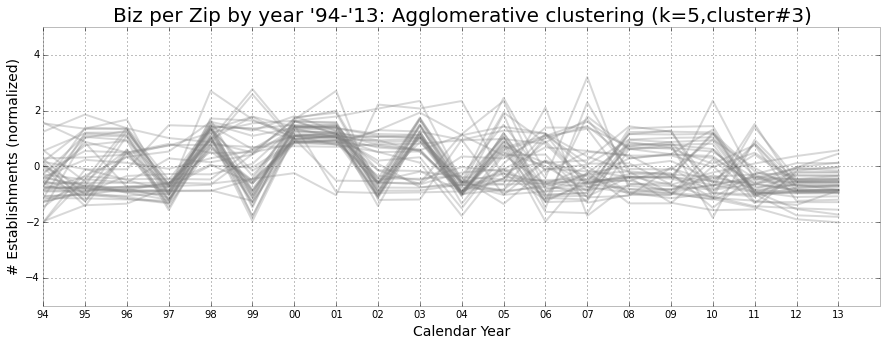

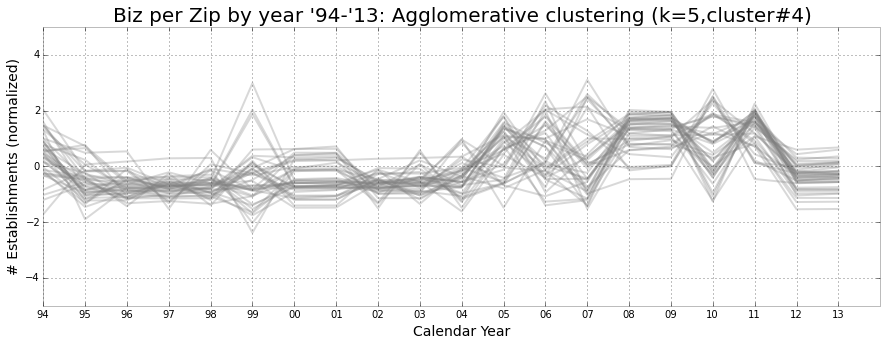

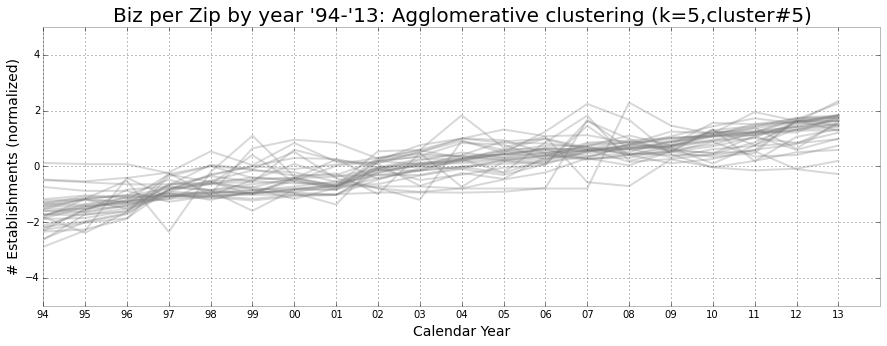

In [193]:
# agg cluster
aggplot(df_norm, 5, cluster_agg5)

## Task 5: Overlay on NYC map

In [195]:
# add cluster groupings to dataframe
df_bizdata['km3'] = labels_km3
df_bizdata['km5'] = labels_km5
df_bizdata['agg3'] = cluster_agg3
df_bizdata['agg5'] = cluster_agg5

/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [200]:
# merge with shapefiles
df_shapeidx = df_shape.set_index('zip_code')
df_map = df_shapeidx.join(df_bizdata)

In [187]:
# kelly_colors
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    